# TFIDF + Logistic Regression

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import itertools

%matplotlib inline

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_predict

In [3]:
data = pd.read_csv('../Data/train.csv')
data[0:10]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [4]:
X = data.comment_text
X[0:10]

0    Explanation\nWhy the edits made under my usern...
1    D'aww! He matches this background colour I'm s...
2    Hey man, I'm really not trying to edit war. It...
3    "\nMore\nI can't make any real suggestions on ...
4    You, sir, are my hero. Any chance you remember...
5    "\n\nCongratulations from me as well, use the ...
6         COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
7    Your vandalism to the Matt Shirvington article...
8    Sorry if the word 'nonsense' was offensive to ...
9    alignment on this subject and which are contra...
Name: comment_text, dtype: object

In [5]:
tags = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
Y = data[tags]
Y[0:10]

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0
5,0,0,0,0,0,0
6,1,1,1,0,1,0
7,0,0,0,0,0,0
8,0,0,0,0,0,0
9,0,0,0,0,0,0


In [6]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          figsize=(9, 7)):
    matrix = confusion_matrix(y_true, y_pred)

    if normalize:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=figsize)
    plt.imshow(matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt),
                 horizontalalignment="center",
                 size=int((figsize[0] / 10) * 38),
                 color="white" if matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [21]:
def show_scores(pipeline, x = X, y = Y):
    for tag in tags:
        print('*****',tag,'*****')
        print('Cross val score', cross_val_score(pipeline, x, y[tag], cv=3, n_jobs=2))
        predict = cross_val_predict(pipeline, x, y[tag], cv=3, n_jobs=2)
        print('Accuracy',accuracy_score(y[tag], predict))
        print('Precision', precision_score(y[tag], predict))
        print('Recall', recall_score(y[tag], predict))
        plot_confusion_matrix(y[tag], predict, classes=[0, 1], normalize=True)

## Да натренираме baseline модел

***** toxic *****
Cross val score [ 0.95549999  0.95559316  0.95589397]
Accuracy 0.955662369729
Precision 0.918354881401
Recall 0.589839152609


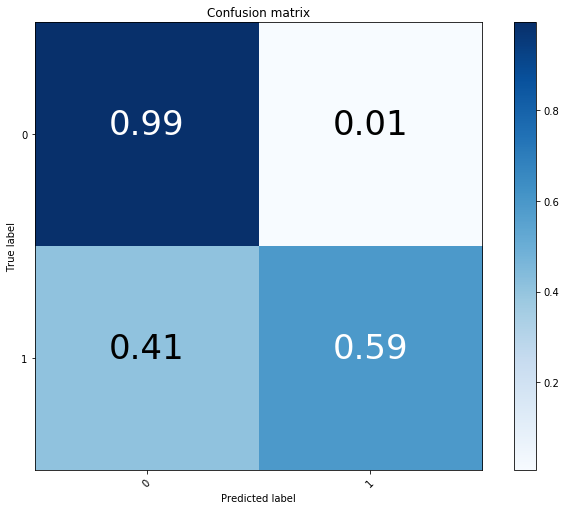

***** severe_toxic *****
Cross val score [ 0.99076912  0.99043071  0.99097558]
Accuracy 0.99072513176
Precision 0.584434654919
Recall 0.249529780564


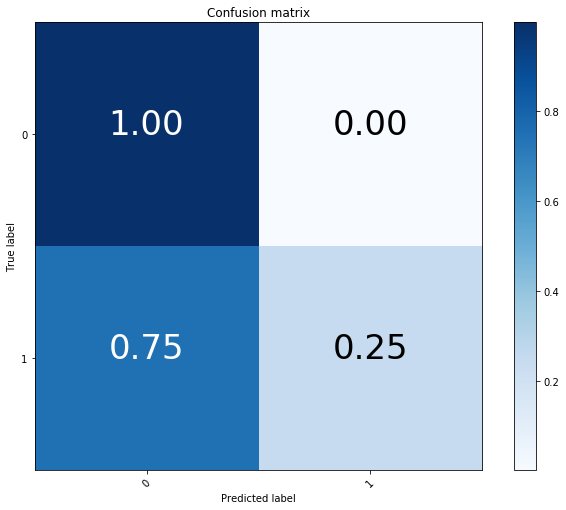

***** obscene *****
Cross val score [ 0.97663139  0.97674375  0.97634894]
Accuracy 0.97657469089
Precision 0.921151439299
Recall 0.609776304888


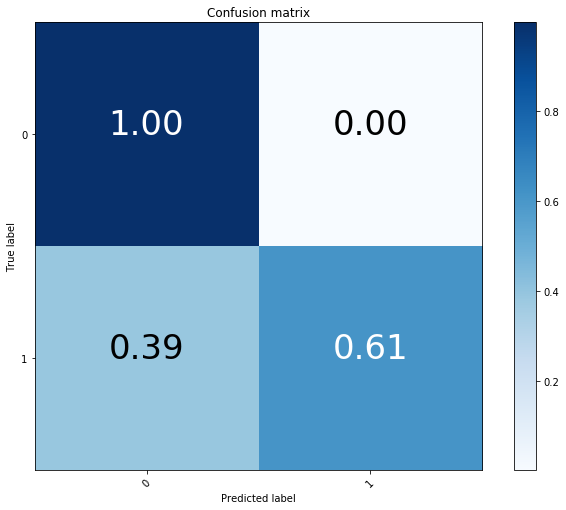

***** threat *****
Cross val score [ 0.99712357  0.99719872  0.99727392]
Accuracy 0.997198739119
Precision 0.67032967033
Recall 0.127615062762


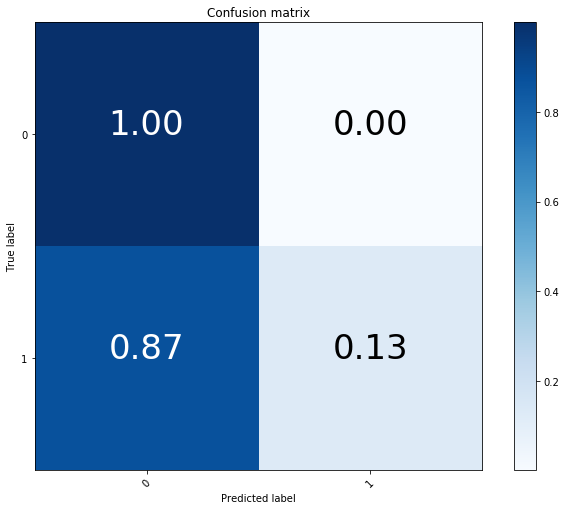

***** insult *****
Cross val score [ 0.97018293  0.97037093  0.97129106]
Accuracy 0.970614961365
Precision 0.827848621966
Recall 0.510981338073


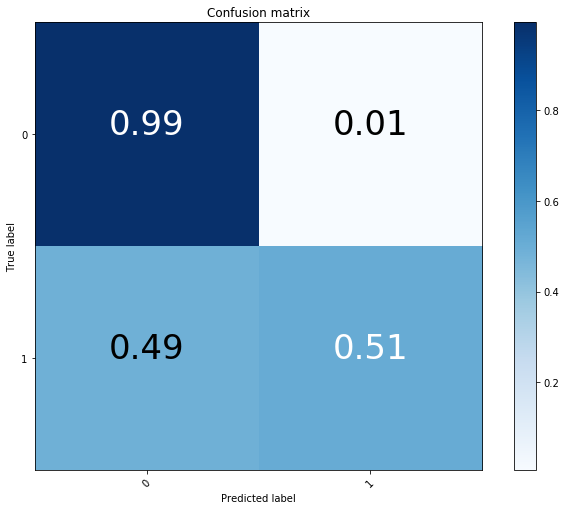

***** identity_hate *****
Cross val score [ 0.99176552  0.99185937  0.99176537]
Accuracy 0.991796755049
Precision 0.654838709677
Recall 0.144483985765


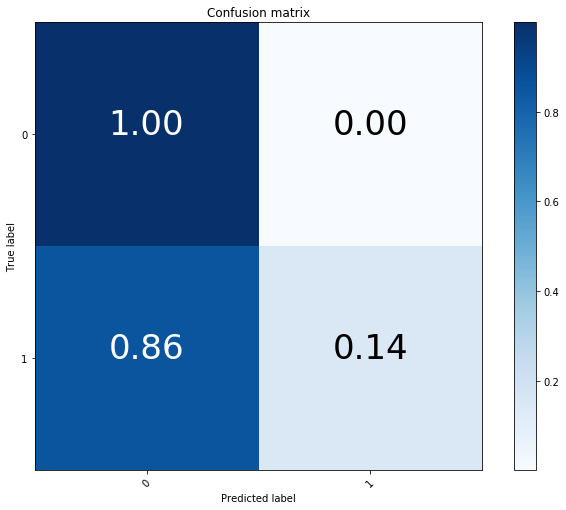

In [22]:
baseline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('logreg', LogisticRegression())
])

show_scores(baseline)

## Нека се опитаме да оптимизираме модела чрез random search

In [23]:
import nltk
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/vananiev/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [26]:
params = {
    "tfidf__ngram_range": [(1,1), (1,2), (1,3)],
    "tfidf__analyzer": ['word'],
    "tfidf__max_df":[1.0, 0.9, 0.8, 0.7, 0.6, 0.5],
    "tfidf__min_df":[2, 3, 5, 10],
    "tfidf__lowercase": [False, True],
    "tfidf__stop_words": [None, stopwords],
    "logreg__C": [0.01, 0.1, 0.3, 1, 3, 10]
}

random_search = RandomizedSearchCV(baseline, param_distributions=params, 
                                       scoring='neg_log_loss',
                                       n_iter=10, cv=2, n_jobs=2)

def show_save_best_params(y, name):
    print('*****', name, '*****')
    random_search.fit(X, y)
    best_params = random_search.best_params_
    print(best_params, random_search.best_score_)
    return best_params

best_params = {}
for tag in tags:
    best_params[tag] = show_save_best_params(Y[tag], tag)

***** toxic *****
{'tfidf__stop_words': None, 'tfidf__ngram_range': (1, 3), 'tfidf__min_df': 10, 'tfidf__max_df': 0.6, 'tfidf__lowercase': True, 'tfidf__analyzer': 'word', 'logreg__C': 10} -0.114423282251
***** severe_toxic *****
{'tfidf__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out'

## Да натренираме финалния модел

In [26]:
test = pd.read_csv('../Data/test.csv')

In [76]:
predictions = []
for tag in tags:
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('logreg', LogisticRegression())
    ])
    
    pipeline.set_params(**best_params[tag])
    
    model = pipeline.fit(X, Y[tag])
    
    predictions.append(model.predict_proba(test.comment_text)[:,1])
    

In [86]:
submit_file = pd.DataFrame(np.array(predictions).T, columns=tags, index=test.id)
submit_file.head(10)


,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,
00001cee341fdb12,0.999933,0.143457,0.998823,0.063472,0.960850,0.231907
0000247867823ef7,0.004319,0.001767,0.001517,0.000397,0.007187,0.000509
00013b17ad220c46,0.001152,0.000692,0.011267,0.000420,0.019730,0.003184
00017563c3f7919a,0.000933,0.002588,0.001898,0.000575,0.001686,0.000097
00017695ad8997eb,0.005841,0.002121,0.004711,0.001226,0.007835,0.001062
0001ea8717f6de06,0.002914,0.000559,0.001889,0.002467,0.008120,0.000579
00024115d4cbde0f,0.004220,0.000234,0.002064,0.000379,0.003969,0.001336
000247e83dcc1211,0.634444,0.001604,0.037228,0.001472,0.139468,0.000845
00025358d4737918,0.003051,0.002295,0.005715,0.000776,0.005596,0.000776


In [88]:
submit_file.to_csv('../Submissions/tfidf-logistic-regression.csv')

# Резултат в Kaggle: 0.9705

# Дали ще се подобри резултата ако намалим боря на чистите/ увеличим боря на токсичните коментари?

## 1. Да намалим чистите коментари на половина..

In [12]:
all_toxic = data[data.toxic + data.severe_toxic + data.obscene + data.threat + data.insult + data.identity_hate > 0]
all_clear = data[data.toxic + data.severe_toxic + data.obscene + data.threat + data.insult + data.identity_hate == 0]

In [23]:
first, second = np.split(all_clear, 2, axis=0)
first = first.append(all_toxic)
first

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0
10,0005300084f90edc,"""\nFair use rationale for Image:Wonju.jpg\n\nT...",0,0,0,0,0,0


***** toxic *****
Cross val score [ 0.93139932  0.93136285  0.92405884]
Accuracy 0.928940362693
Precision 0.905667144907
Recall 0.660389695305


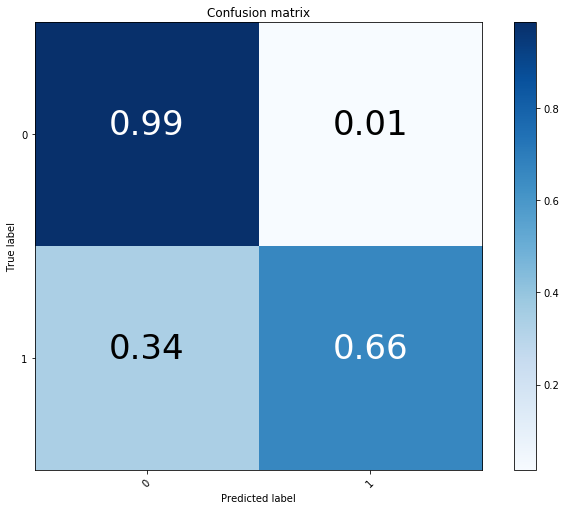

***** severe_toxic *****
Cross val score [ 0.98491468  0.98477816  0.92637723]
Accuracy 0.965357573551
Precision 0.212301587302
Recall 0.335423197492


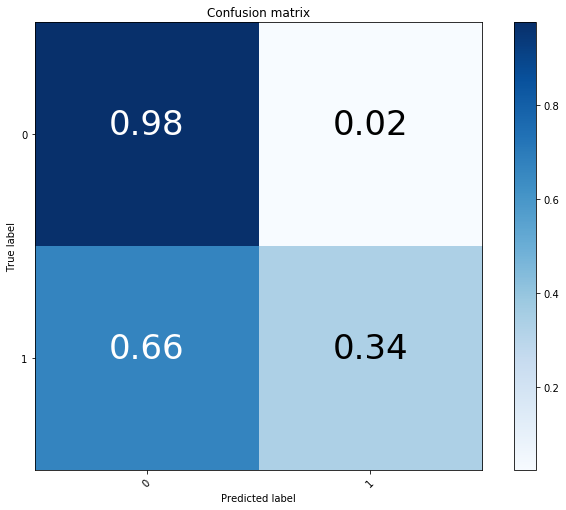

***** obscene *****
Cross val score [ 0.96122867  0.96074951  0.93248916]
Accuracy 0.951489226148
Precision 0.817478379609
Recall 0.637708604569


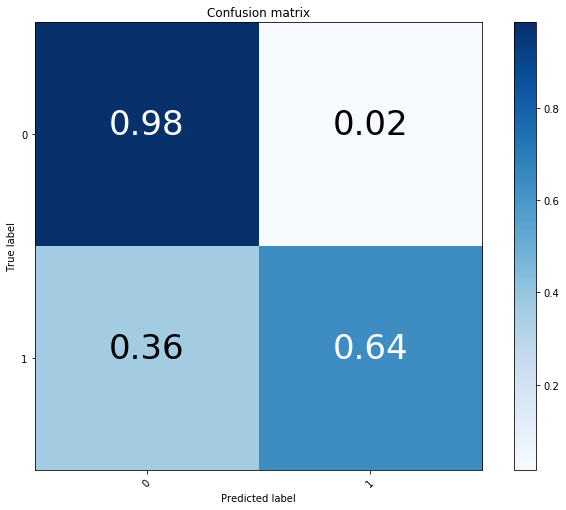

***** threat *****
Cross val score [ 0.99484642  0.9953582   0.97279771]
Accuracy 0.987667523721
Precision 0.110539845758
Recall 0.179916317992


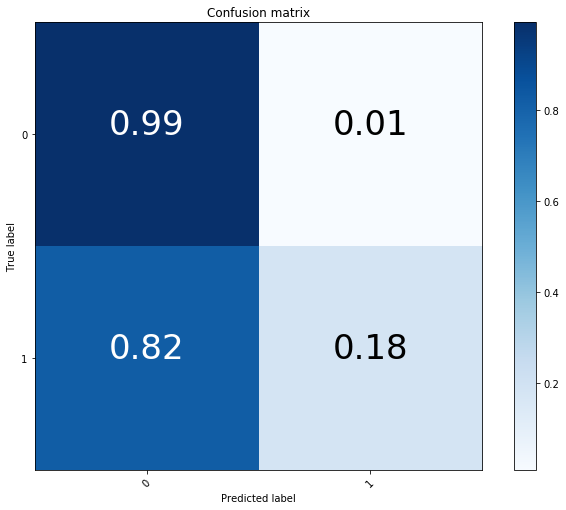

***** insult *****
Cross val score [ 0.95273038  0.95235495  0.90385009]
Accuracy 0.936312544085
Precision 0.679138500236
Recall 0.548432144217


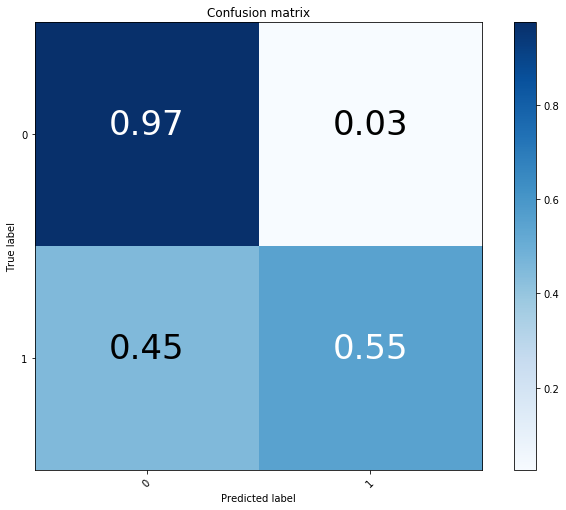

***** identity_hate *****
Cross val score [ 0.98569966  0.98597222  0.91760811]
Accuracy 0.963093585747
Precision 0.127883447997
Recall 0.224911032028


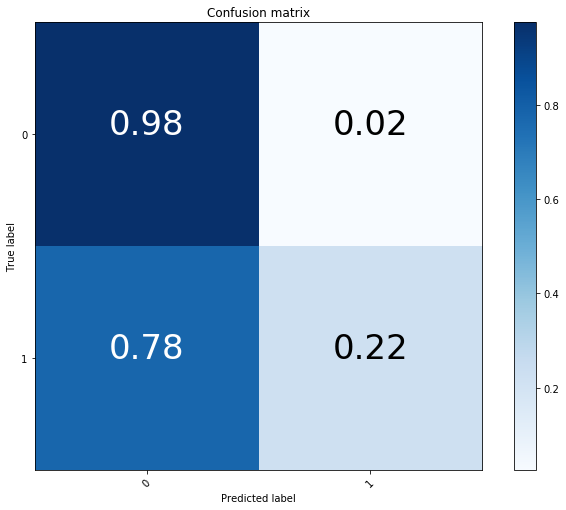

In [25]:
baseline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('logreg', LogisticRegression())
])

show_scores(baseline, first.comment_text, first[tags])

## Precision и Recall на някои класове се подобри, на други се влоши..
#### Не ми се чака рандом сърч в 12 вечерта, затова направо ще събмитна

In [28]:
predictions = []
for tag in tags:
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('logreg', LogisticRegression())
    ])
    
    model = pipeline.fit(first.comment_text, first[tag])
    
    predictions.append(model.predict_proba(test.comment_text)[:,1])

In [29]:
submit_file = pd.DataFrame(np.array(predictions).T, columns=tags, index=test.id)
submit_file.head(10)

,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,
00001cee341fdb12,0.997545,0.186530,0.991542,0.052639,0.950045,0.303750
0000247867823ef7,0.013719,0.002917,0.008168,0.000802,0.011535,0.005824
00013b17ad220c46,0.064495,0.008860,0.032472,0.002954,0.037637,0.008951
00017563c3f7919a,0.006801,0.003233,0.006649,0.001907,0.007964,0.001836
00017695ad8997eb,0.066186,0.006418,0.019800,0.002816,0.020064,0.005753
0001ea8717f6de06,0.016074,0.003380,0.008450,0.003714,0.018805,0.003878
00024115d4cbde0f,0.010179,0.001526,0.008469,0.001079,0.009091,0.002458
000247e83dcc1211,0.663203,0.008210,0.086261,0.003529,0.144842,0.012288
00025358d4737918,0.020814,0.002823,0.016056,0.001688,0.010142,0.004404


In [30]:
submit_file.to_csv('../Submissions/tfidf-logistic-regression-half-clean1.csv')

## Това подобри резултата на 0.9726
### Да пробваме и с другата половина

In [31]:
second = second.append(all_toxic)
second

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
79878,d5bf46ef4a7127bd,"""\n\n Whats wrong with this? you have just pro...",0,0,0,0,0,0
79880,d5c14833d99010bd,Why do you refer to me as an owner of the arti...,0,0,0,0,0,0
79881,d5c2c7cba065f266,Response section \n\nAnyone know what's up wit...,0,0,0,0,0,0
79882,d5c32f33758961f4,"""Hello RHaworth: I always read and consider yo...",0,0,0,0,0,0
79883,d5c3bc61ca7557e0,"HASN'T, not has'nt. Please keep that in mind. ...",0,0,0,0,0,0
79884,d5c3cf814bfa519c,"""The article reads: """"In the first (modern-day...",0,0,0,0,0,0
79886,d5c53f8ca19a82af,"That's well and good, but he still doesn't out...",0,0,0,0,0,0
79887,d5c5b1c2f4aff55c,"""\n\n Moved your article into """"userspace"""" \n...",0,0,0,0,0,0
79888,d5c7bfac18038c89,Very good. Thank you.,0,0,0,0,0,0
79890,d5c8b9405ee1defc,Kwami participated and even initiated personal...,0,0,0,0,0,0


In [32]:
predictions = []
for tag in tags:
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('logreg', LogisticRegression())
    ])
    
    model = pipeline.fit(second.comment_text, second[tag])
    
    predictions.append(model.predict_proba(test.comment_text)[:,1])

In [33]:
submit_file = pd.DataFrame(np.array(predictions).T, columns=tags, index=test.id)
submit_file.head(10)

,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,
00001cee341fdb12,0.997855,0.185128,0.991835,0.053660,0.950226,0.295989
0000247867823ef7,0.012580,0.002845,0.007882,0.000783,0.010983,0.005524
00013b17ad220c46,0.073566,0.009994,0.035275,0.003196,0.038968,0.009886
00017563c3f7919a,0.006605,0.003205,0.006730,0.001855,0.007959,0.001761
00017695ad8997eb,0.068498,0.006680,0.020685,0.002992,0.021225,0.006075
0001ea8717f6de06,0.013330,0.003083,0.007533,0.003509,0.014749,0.003783
00024115d4cbde0f,0.009334,0.001461,0.007925,0.001058,0.008462,0.002384
000247e83dcc1211,0.578476,0.007831,0.073666,0.003418,0.129980,0.011322
00025358d4737918,0.020052,0.002859,0.016775,0.001784,0.010127,0.004191


In [34]:
submit_file.to_csv('../Submissions/tfidf-logistic-regression-half-clean2.csv')

# Резултат: 0.9725

## Ако намаля коментарите четворно? :D

In [36]:
small_set = np.split(first, 2, axis=0)[0].append(all_toxic)
small_set

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0
10,0005300084f90edc,"""\nFair use rationale for Image:Wonju.jpg\n\nT...",0,0,0,0,0,0


In [37]:
predictions = []
for tag in tags:
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('logreg', LogisticRegression())
    ])
    
    model = pipeline.fit(small_set.comment_text, small_set[tag])
    
    predictions.append(model.predict_proba(test.comment_text)[:,1])

submit_file = pd.DataFrame(np.array(predictions).T, columns=tags, index=test.id)
submit_file.to_csv('../Submissions/tfidf-logistic-regression-quarter-clean.csv')

## Резултат: 0.9716

###### TODO: Move second part to separate notebook, make function for submittion